In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1

import os
from ms_stim_analysis.Analysis.utils import smooth
from ms_stim_analysis.AnalysisTables.decoding_tables import ClusterlessAheadBehindDistance
from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol

os.environ["JAX_PLATFORM_NAME"] = "cpu"


[2025-08-28 10:20:39,550][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


# Control Animal examples


In [3]:
# filter_opto_data({"animal": "Yoshi", "track_type": "early_wtrack"})

# nwb_file_name = "Yoshi20220517_.nwb"
# pos_interval = "pos 11 valid times"

nwb_file_name = "Wallie20220922_.nwb"
pos_interval = "pos 3 valid times"
posterior_fit = "acausal"

nwb_file_name = "Yoshi20220517_.nwb"
pos_interval = "pos 5 valid times"
posterior_fit = "acausal"

key = {"nwb_file_name": nwb_file_name, "interval_list_name": pos_interval}
clusterless_key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + pos_interval,
    "encoding_interval": pos_interval,
}

ClusterlessDecodingV1 & clusterless_key

pos_df = ClusterlessDecodingV1().fetch_linear_position_info(clusterless_key)
results = (ClusterlessDecodingV1() & clusterless_key).fetch_results()


if posterior_fit == "acausal":
    results = results.acausal_posterior
elif posterior_fit == "causal":
    results = results.causal_posterior
else:
    raise ValueError("Invalid posterior_fit: {}".format(posterior_fit))
unstacked_result_states = results.unstack("state_bins")
states = unstacked_result_states.state.values
state_probabilities = unstacked_result_states.sum("position")[0]
position_posterior = unstacked_result_states.sum("state")[0]
decode_pos = position_posterior.idxmax("position").values
# decode_pos = [pos_df.index.values[i] for i in decode_pos]

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": pos_interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

spikes = ClusterlessDecodingV1().fetch_spike_data(clusterless_key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 30, 150)


decode_dist = (
    (ClusterlessAheadBehindDistance() & clusterless_key)
    .fetch1_dataframe()
    .decode_distance.values
)

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/spyglass/decoding/v1/core.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or 

In [ ]:
# # (ClusterlessAheadBehindDistance & clusterless_key).delete()
# import os
# os.environ["JAX_PLATFORMS"]='cpu'
# ClusterlessAheadBehindDistance().populate(clusterless_key)

[2025-03-06 08:27:16,330][WARNING]: Skipped checksum for file with hash: 4a21d613-d9c6-f5c7-9216-e93d6268dddb, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_ec83127c-0d3b-40b3-adb2-aabebc91e194.nc
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is al

{'success_count': 1, 'error_list': []}

In [2]:
entropy_i = -np.sum(position_posterior * np.log(position_posterior), axis=-1).values
entropy_i = smooth(entropy_i, 10, 150)
from Analysis.utils import filter_position_ports, get_running_valid_intervals

non_port = filter_position_ports(opto_key, dlc=True)
non_port = get_running_valid_intervals(opto_key, dlc_pos=True)

t0 = non_port[0][1][0]

NameError: name 'position_posterior' is not defined

Text(0.0, 1.0, 'Posterior Entropy')

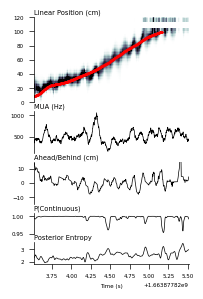

In [52]:
show_stim = False
track_lim = (0, 450)

# Wallie ex) 1
t0 = non_port[0][12][0]
st = np.digitize(t0, pos_df.index.values)
ind = slice(st - 1000, st + 0, None)
track_lim = (0, 120)


# # Wallie ex) 2
# t0 = non_port[0][14][0]
# st = np.digitize(t0, pos_df.index.values)
# ind = slice(st - 1000, st + 0, None)
# track_lim = (150, 300)

# # Yoshi ex) 1
# epoch_st = 16 * 60 + 55
# t0 = 25 * 60 + 54 - epoch_st + pos_df.index.values[0]
# st = np.digitize(t0, pos_df.index.values)
# ind = slice(st - 0, st + 1000, None)
# track_lim = (0, 100)

# # Yoshi ex) 2
# epoch_st = 16*60 + 55
# t0 = 21*60 + 7.3 - epoch_st + pos_df.index.values[0]
# st = np.digitize(t0, pos_df.index.values)
# ind = slice(st - 0, st + 1000, None)
# track_lim = (20, 120)


t_plot = pos_df.index.values[ind]

plt.rcParams.update({"font.size": 4})
lw = 0.5
plt.rcParams.update({"lines.linewidth": lw})
plt.rcParams.update({"axes.linewidth": lw})
plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
plt.rcParams["ytick.major.width"] = lw
figsize = (2, 3.2)
# figsize = (8, 12)

fig, ax_list = plt.subplots(
    5,
    1,
    figsize=figsize,
    sharex=False,
    height_ratios=[4, 2, 2, 1, 1],
)


decode_ax = ax_list[0]
mua_ax = ax_list[1]
dist_ax = ax_list[2]
cont_decode_ax = ax_list[3]
# frag_decode_ax = ax_list[4] # not used
entropy_ax = ax_list[4]

# posterior distribution and true values
clim = None
if posterior_fit == "causal":
    clim = (0, 0.15)
clim = (0, 0.15)

pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
decode_ax.pcolormesh(
    XX,
    YY,
    position_posterior[ind].T,
    cmap="bone_r",
    shading="nearest",
    clim=clim,
    rasterized=True,
)
decode_ax.scatter(t_plot, linear_pos[ind], color="r", s=0.15)
# decode_ax.scatter(t_plot, decode_pos[ind], color="teal", s=3)
decode_ax.set_ylim(track_lim)

# mua
mua_ax.plot(t_plot, mua[ind] / np.mean(np.diff(t_plot)), color="k")
# decode distance
dist_ax.plot(t_plot, smooth(decode_dist, 2, 10)[ind], color="k")
dist_ax.set_ylim(-15, 15)
# p(continous)
if posterior_fit == "acausal":
    scale = 0.05
else:
    scale = 0.4
val = state_probabilities[ind, 0]
mid = np.median(val)
rng = mid - scale, min(mid + scale, 1.01)
cont_decode_ax.plot(t_plot, val, color="k")
cont_decode_ax.set_ylim(rng)
# # p(frag)
# val = state_probabilities[ind, 1]
# mid = np.median(val)
# rng = max(-0.01, mid - scale), min(mid + scale, 1.01)
# frag_decode_ax.plot(t_plot, val, color="k")
# frag_decode_ax.set_ylim(rng)

# entropy
entropy_ax.plot(t_plot, entropy_i[ind], color="k")

if show_stim:
    plot_marks = stim_time[stim == 1]
    plot_marks = plot_marks[(plot_marks > t_plot[0]) & (plot_marks < t_plot[-1])]
    for ax in ax_list:
        ax.vlines(plot_marks, *ax.get_ylim(), color="thistle", alpha=0.5, lw=2)

for ax in ax_list:
    ax.set_xlim(t_plot[0], t_plot[-1])

for ax in ax_list[:-1]:
    ax.spines[["top", "right", "bottom"]].set_visible(False)
    ax.set_xticks([])
ax_list[-1].spines[["top", "right"]].set_visible(False)
ax_list[-1].set_xlabel("Time (s)")

# fig.suptitle(
#     f"{nwb_file_name}, {pos_interval}, start_index={st}",
# )

# AXIS LABELING OPTIONS
# mua_ax.set_ylabel("MUA (Hz)")
# dist_ax.set_ylabel("Ahead/Behind (cm)")
# decode_ax.set_ylabel("Linear Position (cm)")
# cont_decode_ax.set_ylabel("P(Continuous)")
# frag_decode_ax.set_ylabel("P(Fragmented)")
# entropy_ax.set_ylabel("Posterior Entropy")

title_pad = 2
mua_ax.set_title("MUA (Hz)", loc="left", pad=title_pad)
dist_ax.set_title("Ahead/Behind (cm)", loc="left", pad=title_pad)
decode_ax.set_title("Linear Position (cm)", loc="left", pad=title_pad)
cont_decode_ax.set_title("P(Continuous)", loc="left", pad=title_pad)
# frag_decode_ax.set_title("P(Fragmented)", loc="left", pad=title_pad)
entropy_ax.set_title("Posterior Entropy", loc="left", pad=title_pad)

In [9]:
posterior_fit, st

('acausal', 269501)

In [53]:
plt.rcParams["svg.fonttype"] = "none"
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
fig.savefig(
    f"Figures_20250210/wtrack_examples_{nwb_file_name.split('_')[0]}_{pos_interval}_index{st}"
    + f"{'_stim' if show_stim else ''}_{posterior_fit}_rasterized.svg"
)

# Test animal example

In [54]:
# filter_opto_data({"animal": "Yoshi", "track_type": "early_wtrack"})

# nwb_file_name = "Yoshi20220517_.nwb"
# pos_interval = "pos 11 valid times"

nwb_file_name = "Winnie20220719_.nwb"
pos_interval = "pos 3 valid times"
posterior_fit = "acausal"

# nwb_file_name = "Frodo20230814_.nwb"
# pos_interval = "pos 15 valid times"
# posterior_fit = "acausal"


key = {"nwb_file_name": nwb_file_name, "interval_list_name": pos_interval}
clusterless_key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + pos_interval,
    "encoding_interval": pos_interval,
}

ClusterlessDecodingV1 & clusterless_key

pos_df = ClusterlessDecodingV1().fetch_linear_position_info(clusterless_key)
results = (ClusterlessDecodingV1() & clusterless_key).fetch_results()


if posterior_fit == "acausal":
    results = results.acausal_posterior
elif posterior_fit == "causal":
    results = results.causal_posterior
else:
    raise ValueError("Invalid posterior_fit: {}".format(posterior_fit))
unstacked_result_states = results.unstack("state_bins")
states = unstacked_result_states.state.values
state_probabilities = unstacked_result_states.sum("position")[0]
position_posterior = unstacked_result_states.sum("state")[0]
decode_pos = position_posterior.idxmax("position").values
# decode_pos = [pos_df.index.values[i] for i in decode_pos]

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": pos_interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

spikes = ClusterlessDecodingV1().fetch_spike_data(clusterless_key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 30, 150)


decode_dist = (
    (ClusterlessAheadBehindDistance() & clusterless_key)
    .fetch1_dataframe()
    .decode_distance.values
)

[2025-03-06 14:29:32,654][WARNING]: Skipped checksum for file with hash: b8728e1b-151c-6312-0809-6d6cd6900bd2, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_89e4a112-1e04-4a7e-b65e-01d4093b8431.nc
[2025-03-06 14:29:43,979][WARNING]: Skipped checksum for file with hash: 6ffccb1d-60cb-2b9e-f84a-b61d2483a2ad, and path: /stelmo/nwb/raw/Winnie20220719_.nwb


In [55]:
entropy_i = -np.sum(position_posterior * np.log(position_posterior), axis=-1).values
entropy_i = smooth(entropy_i, 10, 50)
from Analysis.utils import filter_position_ports, get_running_valid_intervals

non_port = filter_position_ports(opto_key, dlc=True)
non_port = get_running_valid_intervals(opto_key, dlc_pos=True)

t0 = non_port[0][1][0]

Text(0.0, 1.0, 'Posterior Entropy')

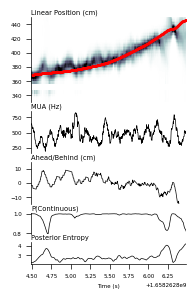

In [59]:
show_stim = False
track_lim = (0, 450)

# # Winnie ex) 1
# # t0 = non_port[0][42][0]
# st = np.digitize(t0, pos_df.index.values)
# ind = slice(st + 500, st + 1500, None)
# track_lim = (330, 450)
# ind = slice(st -1000, st + 1000, None)
# track_lim = (0, 250)

# # Winnie ex) 2
# st = 485596
# ind = slice(st - 500, st + 500, None)
# track_lim = (180,280)

# # Winnie ex) 3
# st = 14501
# ind = slice(st, st + 1000, None)
# track_lim = (100, 168)

# Winnie ex 4
st = 41250
ind = slice(st + 500, st + 1500, None)
track_lim = (330, 450)

# # # Frodo ex) 1
# epoch_st = 59 * 60 + 3
# t0 = 60 * 60 + 12 - epoch_st + pos_df.index.values[0]
# st = np.digitize(t0, pos_df.index.values)
# ind = slice(st - 0, st + 1000, None)
# track_lim = (0, 100)

# # # Frodo ex) 2
# epoch_st = 59*60 + 3
# t0 = 64*60 + 14 - epoch_st + pos_df.index.values[0]
# st = np.digitize(t0, pos_df.index.values)
# ind = slice(st - 100, st + 900, None)
# track_lim = (0, 100)


t_plot = pos_df.index.values[ind]

plt.rcParams.update({"font.size": 4})
lw = 0.5
plt.rcParams.update({"lines.linewidth": lw})
plt.rcParams.update({"axes.linewidth": lw})
plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
plt.rcParams["ytick.major.width"] = lw
figsize = (2, 3.2)
# figsize = (8,12)

fig, ax_list = plt.subplots(
    5,
    1,
    figsize=figsize,
    sharex=False,
    height_ratios=[4, 2, 2, 1, 1],
)
decode_ax = ax_list[0]
mua_ax = ax_list[1]
dist_ax = ax_list[2]
cont_decode_ax = ax_list[3]
# frag_decode_ax = ax_list[4] # not used
entropy_ax = ax_list[4]

# posterior distribution and true values
clim = None
if posterior_fit == "causal":
    clim = (0, 0.15)
clim = (0, 0.15)

pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
decode_ax.pcolormesh(
    XX,
    YY,
    position_posterior[ind].T,
    cmap="bone_r",
    shading="nearest",
    clim=clim,
    rasterized=True,
)
decode_ax.scatter(t_plot, linear_pos[ind], color="r", s=0.15)
# decode_ax.scatter(t_plot, decode_pos[ind], color="teal", s=3)
decode_ax.set_ylim(track_lim)

# mua
mua_ax.plot(t_plot, mua[ind] / np.mean(np.diff(t_plot)), color="k")
# decode distance
dist_ax.plot(t_plot, smooth(decode_dist, 2, 10)[ind], color="k")
dist_ax.set_ylim(-15, 15)
# p(continous)
if posterior_fit == "acausal":
    scale = 0.05
    scale = 0.2
else:
    scale = 0.4
val = state_probabilities[ind, 0]
mid = np.median(val)
rng = max(mid - scale, -0.01), min(mid + scale, 1.01)
cont_decode_ax.plot(t_plot, val, color="k")
cont_decode_ax.set_ylim(rng)
# # p(frag)
# val = state_probabilities[ind, 1]
# mid = np.median(val)
# rng = mid - scale, min(mid + scale, 1.01)
# frag_decode_ax.plot(t_plot, val, color="k")
# frag_decode_ax.set_ylim(rng)

# entropy
entropy_ax.plot(t_plot, entropy_i[ind], color="k")

if show_stim:
    plot_marks = stim_time[stim == 1]
    plot_marks = plot_marks[(plot_marks > t_plot[0]) & (plot_marks < t_plot[-1])]
    for ax in ax_list:
        ax.vlines(plot_marks, *ax.get_ylim(), color="thistle", alpha=0.5, lw=2)

for ax in ax_list:
    ax.set_xlim(t_plot[0], t_plot[-1])

for ax in ax_list[:-1]:
    ax.spines[["top", "right", "bottom"]].set_visible(False)
    ax.set_xticks([])
ax_list[-1].spines[["top", "right"]].set_visible(False)
ax_list[-1].set_xlabel("Time (s)")

# fig.suptitle(
#     f"{nwb_file_name}, {pos_interval}, start_index={st}",
# )

# AXIS LABELING OPTIONS
# mua_ax.set_ylabel("MUA (Hz)")
# dist_ax.set_ylabel("Ahead/Behind (cm)")
# decode_ax.set_ylabel("Linear Position (cm)")
# cont_decode_ax.set_ylabel("P(Continuous)")
# frag_decode_ax.set_ylabel("P(Fragmented)")
# entropy_ax.set_ylabel("Posterior Entropy")

pad = 2
mua_ax.set_title("MUA (Hz)", loc="left", pad=pad)
dist_ax.set_title("Ahead/Behind (cm)", loc="left", pad=pad)
decode_ax.set_title("Linear Position (cm)", loc="left", pad=pad)
cont_decode_ax.set_title("P(Continuous)", loc="left", pad=pad)
# frag_decode_ax.set_title("P(Fragmented)", loc="left",pad=pad)
entropy_ax.set_title("Posterior Entropy", loc="left", pad=pad)

# dist_ax.set_ylim(-25, 25)

In [61]:
plt.rcParams["svg.fonttype"] = "none"
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
fig.savefig(
    f"Figures_20250210/wtrack_examples_{nwb_file_name.split('_')[0]}_{pos_interval}_index{st}"
    + f"{'_stim' if show_stim else ''}_{posterior_fit}_rasterized.svg"
)